In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import torch
from pathlib import Path
from ema_pytorch import EMA
from datetime import datetime
from utils.sim_utils import *
from utils.eval_utils import *
from utils.train_utils import *
from utils.couzin_utils import *
from utils.vec_sim_utils import *
from utils.encoder_utils import *
from geomloss import SamplesLoss
from utils.mmd_loss import MMDLoss
from models.Generator import ModularPolicy
from models.Discriminator import Discriminator

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [ ]:
# Expert Data Generation
max_steps = 300         # steps per episode

# Training Setup
num_generations = 3     # training generations
gamma = 0.999           # decay factor
pretrain=False          # BC pretrain
performance_eval = 5    # evaluate performance every n generations
num_perturbations = 64  # perturbations for ES

### Prey ###
lr_prey_policy = 2e-4   # learning rate prey policy
sigma_prey = 0.1        # prey scatter for ES (exploration)

prey_dis_balance_factor = 2 # prey discriminator steps per policy step
prey_noise = 0.005      # prey discriminator input noise
lr_prey_disc = 5e-4     # learning rate prey discriminator
lambda_gp_prey = 5      # prey gradient penalty factor
prey_update_mode = {"mode": "avoid", "lambda": None} # prey update mode


### Predator ###
lr_pred_policy = 1e-4   # learning rate predator policy
sigma_pred = 0.08       # pred scatter for ES (exploration)

pred_dis_balance_factor = 2 # pred discriminator steps per policy step
pred_noise = 0.005      # pred discriminator input noise
lr_pred_disc = 2e-4     # learning rate pred discriminator
lambda_gp_pred = 10     # pred gradient penalty factor
pred_update_mode = {"mode": "attack", "lambda": None} # pred update mode


# Env Settings (Expert Generation = Training)
height = 50
width = 50
prey_speed = 5
pred_speed = 5
step_size = 0.25
theta_dot_max = 0.5 # max turn rate
max_turn = float(theta_dot_max * step_size) + 1e-12 # max turn per step

pert_steps = 100 # perturbation steps
init_steps = 500 # initial steps

env_settings = (height, width, prey_speed, pred_speed, step_size, max_turn, pert_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
%matplotlib tk
# generate Expert Data with Couzin Model
exp_pred_sequence, exp_prey_sequence, couzin_metrics, actions, init_pool = run_couzin_simulation(visualization="off", 
                                                                                                 max_steps=init_steps, 
                                                                                                 constant_speed=prey_speed, shark_speed=pred_speed, 
                                                                                                 area_width=width, area_height=height,
                                                                                                 dt = step_size,
                                                                                                 alpha=0.01,
                                                                                                 theta_dot_max=theta_dot_max, theta_dot_max_shark=theta_dot_max,
                                                                                                 number_of_sharks=1, n=32)
%matplotlib inline

# move to device (GPU training only)
exp_pred_sequence = exp_pred_sequence.to(device)
exp_prey_sequence = exp_prey_sequence.to(device)
init_pool = init_pool.to(device)

# create windows for training
exp_pred_tensor = sliding_window(exp_pred_sequence, window_size=10)
exp_prey_tensor = sliding_window(exp_prey_sequence, window_size=10)

print("\nPred Tensor Shape:", exp_pred_tensor.shape)
print("Prey Tensor Shape:", exp_prey_tensor.shape)


Pred Tensor Shape: torch.Size([491, 10, 1, 32, 5])
Prey Tensor Shape: torch.Size([491, 10, 32, 32, 6])


epoch 010: loss=22.961678 sim=0.0540 std=1.3066 cov=0.4027 std_mean=0.347
epoch 020: loss=22.273949 sim=0.0460 std=1.2690 cov=0.4175 std_mean=0.365
epoch 030: loss=21.501564 sim=0.0394 std=1.2230 cov=0.4347 std_mean=0.389
epoch 040: loss=21.391834 sim=0.0438 std=1.1966 cov=0.4695 std_mean=0.402
epoch 050: loss=20.976955 sim=0.0430 std=1.1444 cov=0.5474 std_mean=0.428
epoch 060: loss=20.653055 sim=0.0413 std=1.1395 cov=0.5059 std_mean=0.430
epoch 070: loss=20.477240 sim=0.0446 std=1.1188 cov=0.5161 std_mean=0.441
epoch 080: loss=20.541742 sim=0.0404 std=1.1119 cov=0.5705 std_mean=0.444
epoch 090: loss=20.326092 sim=0.0423 std=1.1114 cov=0.5196 std_mean=0.444
epoch 100: loss=20.344301 sim=0.0403 std=1.1018 cov=0.5620 std_mean=0.449


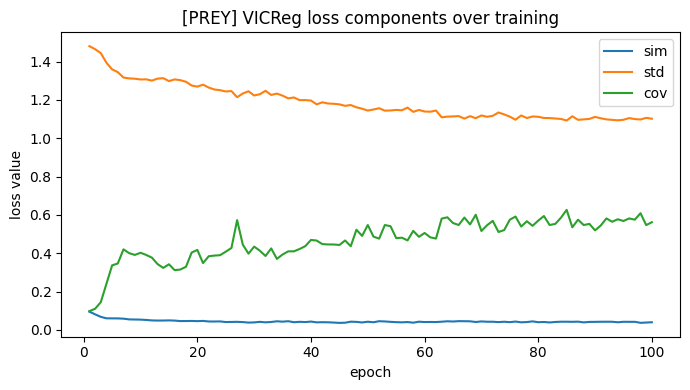

Prey Encoder trained & frozen.

epoch 010: loss=23.990704 sim=0.0518 std=1.4334 cov=0.2387 std_mean=0.283
epoch 020: loss=24.226286 sim=0.0711 std=1.4034 cov=0.2795 std_mean=0.298
epoch 030: loss=23.161545 sim=0.0469 std=1.3678 cov=0.2947 std_mean=0.316
epoch 040: loss=22.884729 sim=0.0349 std=1.3568 cov=0.3319 std_mean=0.322
epoch 050: loss=22.896679 sim=0.0459 std=1.3249 cov=0.3752 std_mean=0.338
epoch 060: loss=23.248959 sim=0.0576 std=1.3173 cov=0.4096 std_mean=0.341
epoch 070: loss=22.902361 sim=0.0359 std=1.3138 cov=0.4596 std_mean=0.343
epoch 080: loss=22.788252 sim=0.0401 std=1.3358 cov=0.3496 std_mean=0.332


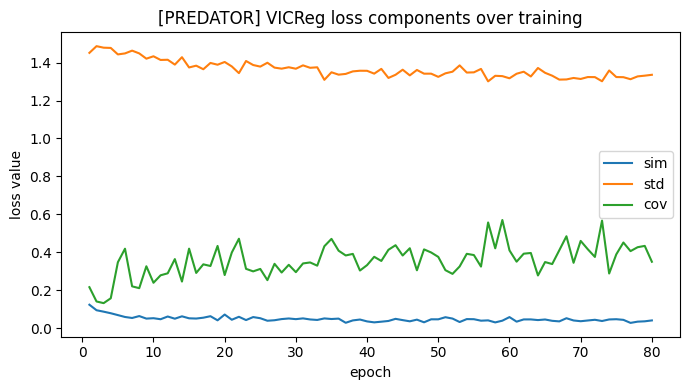

Predator Encoder trained & frozen.


In [4]:
# initialize trajectory augmentation
aug = TrajectoryAugmentation(noise_std=0.01, neigh_drop=0.10, feat_drop=0.05).to(device)

# prey encoder training
prey_encoder = TransitionEncoder(features=5, embd_dim=32, z=32).to(device)
prey_projector = VicRegProjector(input_dim=64).to(device)
prey_optimizer = torch.optim.Adam(list(prey_encoder.parameters()) + list(prey_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(prey_encoder, prey_projector, aug=aug, exp_tensor=exp_prey_tensor, epochs=100, optimizer=prey_optimizer, role="prey")

# freeze prey encoder
for p in prey_encoder.parameters():
    p.requires_grad = False 
prey_encoder.eval()
print("Prey Encoder trained & frozen.\n")

# predator encoder training
pred_encoder = TransitionEncoder(features=4, embd_dim=32, z=32).to(device)
pred_projector = VicRegProjector(input_dim=64).to(device)
pred_optimizer = torch.optim.Adam(list(pred_encoder.parameters()) + list(pred_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(pred_encoder, pred_projector, aug=aug, exp_tensor=exp_pred_tensor, epochs=80, optimizer=pred_optimizer, role="predator")

# freeze predator encoder
for p in pred_encoder.parameters():
    p.requires_grad = False
pred_encoder.eval()
print("Predator Encoder trained & frozen.")

In [5]:
# initialize prey policy 
prey_policy = ModularPolicy(features=5).to(device)
prey_policy.set_parameters()

# pretrain prey policy with behavior cloning
if pretrain:
    pretrain_policy(prey_policy, "prey", expert_data=exp_prey_tensor, batch_size=4048, epochs=5, lr=1e-3, deterministic=True, device=device)

# initialize EMA for prey policy
ema_prey = EMA(prey_policy, beta=0.9999, update_after_step=10, update_every=5, allow_different_devices=True)
print("Prey Policy initialized.\n")

Prey Policy initialized.



In [6]:
# initialize predator policy
pred_policy = ModularPolicy(features=4).to(device)
pred_policy.set_parameters()

# pretrain predator policy with behavior cloning
if pretrain:
    pretrain_policy(pred_policy, "predator", expert_data=exp_pred_tensor, batch_size=4048, epochs=5, lr=1e-3, deterministic=True, device=device)

# initialize EMA for predator policy
ema_pred = EMA(pred_policy, beta=0.9999, update_after_step=10, update_every=5, allow_different_devices=True)
print("Predator Policy initialized.\n")

Predator Policy initialized.



In [7]:
# initialize prey discriminator
prey_discriminator = Discriminator(encoder=prey_encoder, role="prey", z_dim=32).to(device)
prey_discriminator.set_parameters(init=True)
optim_disc_prey = torch.optim.RMSprop(prey_discriminator.parameters(), lr=lr_prey_disc, alpha=0.99, eps=1e-08)

# initialize predator discriminator
pred_discriminator = Discriminator(encoder=pred_encoder, role="predator", z_dim=32).to(device)
pred_discriminator.set_parameters(init=True)
optim_disc_pred = torch.optim.RMSprop(pred_discriminator.parameters(), lr=lr_pred_disc, alpha=0.99, eps=1e-08)

# initialize losses
prey_mmd_loss = MMDLoss(encoder=prey_encoder, role="prey").to(device)
pred_mmd_loss = MMDLoss(encoder=pred_encoder, role="predator").to(device)
sinkhorn_loss = SamplesLoss(loss="sinkhorn", backend="tensorized")

In [ ]:
metrics_list = []
policy_metrics_list = []
disc_metrics_list = []

# Training Loop
for gen in range(num_generations):
    # use EMA models for rollouts
    rollout_prey_policy = ema_prey.ema_model.to(device)
    rollout_pred_policy = ema_pred.ema_model.to(device)
    
    # generate rollouts with current EMA policy
    gen_pred_tensor, gen_prey_tensor = run_env_vectorized(prey_policy=rollout_prey_policy, 
                                                          pred_policy=rollout_pred_policy, 
                                                          n_prey=32, n_pred=1, max_steps=100,
                                                          init_pool=init_pool)


    for i in range(pred_dis_balance_factor):
        # sample batches for discriminator update
        expert_pred_batch = sample_data(exp_pred_tensor, batch_size=20, window_len=10).to(device)
        generative_pred_batch = sample_data(gen_pred_tensor, batch_size=20, window_len=10).to(device)

        # predator discriminator update
        dis_metric_pred = pred_discriminator.update(expert_pred_batch, generative_pred_batch, optim_disc_pred, 
                                                    lambda_gp_pred, noise=pred_noise, generation=gen, num_generations=num_generations)


    for i in range(prey_dis_balance_factor):
        # sample batches for discriminator update
        expert_prey_batch = sample_data(exp_prey_tensor, batch_size=10, window_len=10).to(device)
        generative_prey_batch = sample_data(gen_prey_tensor, batch_size=10, window_len=10).to(device)

        # prey discriminator update
        dis_metric_prey = prey_discriminator.update(expert_prey_batch, generative_prey_batch, optim_disc_prey, 
                                                    lambda_gp_prey, noise=prey_noise, generation=gen, num_generations=num_generations)

        disc_metrics_list.append((dis_metric_prey, dis_metric_pred))                                            
    
    # sample initial positions for ES, same positions for all perturbations
    init_pos = init_positions(init_pool, batch=num_perturbations, mode="dual")

    # optimize pred PIN with ES
    pin_pred_metrics = optimize_es(pred_policy=pred_policy, prey_policy=prey_policy,
                                   role="pred", module="pairwise", mode=pred_update_mode, 
                                   discriminator=pred_discriminator, lr=lr_pred_policy, sigma=sigma_pred, 
                                   num_perturbations=num_perturbations, init_pos=init_pos, 
                                   settings_batch_env=env_settings)
    
    # optimize pred AN with ES
    an_pred_metrics  = optimize_es(pred_policy=pred_policy, prey_policy=prey_policy,
                                   role="pred", module="attention", mode=pred_update_mode, 
                                   discriminator=pred_discriminator, lr=lr_pred_policy, sigma=sigma_pred,
                                   num_perturbations=num_perturbations, init_pos=init_pos,
                                   settings_batch_env=env_settings)
    ema_pred.update() # update EMA predator policy

    # optimize prey PIN with ES
    pin_prey_metrics = optimize_es(pred_policy=pred_policy, prey_policy=prey_policy,
                                   role="prey", module="pairwise", mode=prey_update_mode, 
                                   discriminator=prey_discriminator, lr=lr_prey_policy, sigma=sigma_prey, 
                                   num_perturbations=num_perturbations, init_pos=init_pos, 
                                   settings_batch_env=env_settings)
    
    # optimize prey AN with ES
    an_prey_metrics  = optimize_es(pred_policy=pred_policy, prey_policy=prey_policy,
                                   role="prey", module="attention", mode=prey_update_mode, 
                                   discriminator=prey_discriminator, lr=lr_prey_policy, sigma=sigma_prey,
                                   num_perturbations=num_perturbations, init_pos=init_pos,
                                   settings_batch_env=env_settings)
    ema_prey.update() # update EMA prey policy

    # append metrics
    policy_metrics_list.append({"predator": (pin_pred_metrics, an_pred_metrics), "prey": (pin_prey_metrics, an_prey_metrics)})
    
    # decay learning rate and sigma
    lr_pred_policy *= gamma
    lr_prey_policy *= gamma
    sigma_pred *= gamma
    sigma_prey *= gamma

    # evalute current policies
    current_prey_state = ema_prey.ema_model.state_dict()
    current_pred_state = ema_pred.ema_model.state_dict()

    if gen % performance_eval == 0:
        # caluclate Sinkhorn and MMD metrics
        metrics = calculate_metrics(pred_policy=pred_policy, prey_policy=prey_policy, 
                                    prey_encoder=prey_encoder, pred_encoder=pred_encoder,
                                    exp_prey_tensor=exp_prey_tensor, exp_pred_tensor=exp_pred_tensor,
                                    prey_mmd_loss=prey_mmd_loss, pred_mmd_loss=pred_mmd_loss, sinkhorn_loss=sinkhorn_loss,
                                    init_pool=init_pool, env_settings=env_settings, device="cuda")
        metrics_list.append(metrics)

        # save best policies based on Sinkhorn distance
        best_prey = metrics["sinkhorn_prey_mean"]
        best_prey_policy_state = {key: value.detach().clone() for key, value in current_prey_state.items()}

        best_pred = metrics["sinkhorn_pred_mean"]
        best_pred_policy_state = {key: value.detach().clone() for key, value in current_pred_state.items()}
        
    if metrics["sinkhorn_prey_mean"] < best_prey:
        best_prey = metrics["sinkhorn_prey_mean"]
        print(f"New best Prey Sinkhorn: {best_prey.item()}\n")
        best_prey_policy_state = {key: value.detach().clone() for key, value in current_prey_state.items()}

    if metrics["sinkhorn_pred_mean"] < best_pred:
        best_pred = metrics["sinkhorn_pred_mean"]
        print(f"New best Predator Sinkhorn: {best_pred.item()}\n")
        best_pred_policy_state = {key: value.detach().clone() for key, value in current_pred_state.items()}

    print("Generation", gen+1)
    print(f"[PREY] PIN Network:   {pin_prey_metrics}")
    print(f"[PREY] AN Network:    {an_prey_metrics}")
    print(f"[PREY] Discriminator: {dis_metric_prey}")
    print(f"[PREY] Score Diff: {abs(dis_metric_prey['expert_score_mean'] - dis_metric_prey['policy_score_mean'])}")
    print(f"[PREY] MMD: {metrics['mmd_prey_mean']:.4f} ± {metrics['mmd_prey_std']:.4f} | Sinkhorn: {metrics['sinkhorn_prey_mean']:.4f} ± {metrics['sinkhorn_prey_std']:.4f}")
    print("--------------------------------")
    print(f"[PRED] PIN Network:   {pin_pred_metrics}")
    print(f"[PRED] AN Network:    {an_pred_metrics}")
    print(f"[PRED] Discriminator: {dis_metric_pred}")
    print(f"[PRED] Score Diff: {abs(dis_metric_pred['expert_score_mean'] - dis_metric_pred['policy_score_mean'])}")
    print(f"[PRED] MMD: {metrics['mmd_pred_mean']:.4f} ± {metrics['mmd_pred_std']:.4f} | Sinkhorn: {metrics['sinkhorn_pred_mean']:.4f} ± {metrics['sinkhorn_pred_std']:.4f}\n")

# load best policies
prey_policy.load_state_dict(best_prey_policy_state, strict=True)
pred_policy.load_state_dict(best_pred_policy_state, strict=True)

Generation 1
[PREY] PIN Network:   {'diff_mean': -0.009834, 'diff_std': 0.053594, 'delta_norm': 0.091832, 'clip_ratio': 0.691591, 'delta_raw_norm': 0.132783, 'max_delta_norm': 0.091832, 'avoid/attack reward': None}
[PREY] AN Network:    {'diff_mean': -0.000331, 'diff_std': 0.011348, 'delta_norm': 0.093331, 'clip_ratio': 0.718183, 'delta_raw_norm': 0.129955, 'max_delta_norm': 0.093331, 'avoid/attack reward': None}
[PREY] Discriminator: {'dis_loss': -0.0001, 'dis_loss_gp': 4.8865, 'grad_penalty': 0.9773, 'expert_score_mean': -0.1721, 'policy_score_mean': -0.1722}
[PREY] Score Diff: 9.999999999998899e-05
[PREY] MMD: 0.4084 ± 0.0502 | Sinkhorn: 0.0004 ± 0.0001
--------------------------------
[PRED] PIN Network:   {'diff_mean': 0.028761, 'diff_std': 0.121662, 'delta_norm': 0.095586, 'clip_ratio': 0.946742, 'delta_raw_norm': 0.100964, 'max_delta_norm': 0.095586, 'avoid/attack reward': None}
[PRED] AN Network:    {'diff_mean': -0.000252, 'diff_std': 0.038161, 'delta_norm': 0.092782, 'clip_ra

<All keys matched successfully>

In [9]:
# save trained policies
base_dir = Path(r"..\data\2. Training\training\SequencePredPrey - GAIL")
run_dir = base_dir / datetime.now().strftime("%Y.%m.%d_%H.%M")
run_dir.mkdir(parents=True, exist_ok=True)

prey_path = run_dir / "prey_policy.pth"
torch.save(prey_policy.state_dict(), prey_path)

pred_path = run_dir / "pred_policy.pth"
torch.save(pred_policy.state_dict(), pred_path)

In [10]:
# calculate expert baseline for comparison with trained policies
mmd_means, mmd_stds, sinkhorn_means, sinkhorn_stds = get_expert_values(exp_pred_tensor=exp_pred_tensor, exp_prey_tensor=exp_prey_tensor, 
                                                                        prey_mmd_loss=prey_mmd_loss, pred_mmd_loss=pred_mmd_loss, 
                                                                        prey_encoder=prey_encoder, pred_encoder=pred_encoder, 
                                                                        sinkhorn_loss=sinkhorn_loss)

100%|██████████| 500/500 [00:28<00:00, 17.82it/s]


Expert Prey MMD: 0.0475260853767395 ± 0.042011116002176614
Expert Prey Sinkhorn: 0.00019344072056992444 ± 5.403479833857919e-05

Expert Pred MMD: 0.42685947847366335 ± 0.2268128013020205
Expert Pred Sinkhorn: 0.0016844864514423533 ± 0.0004555723765315932


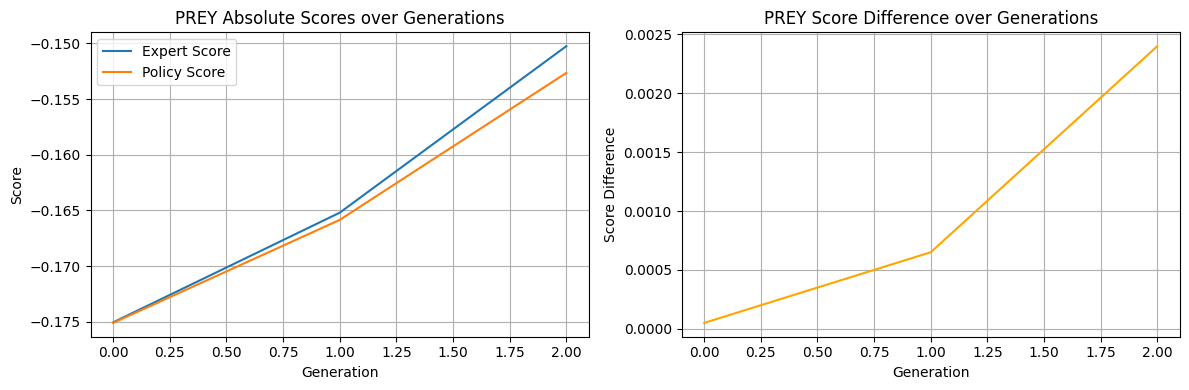

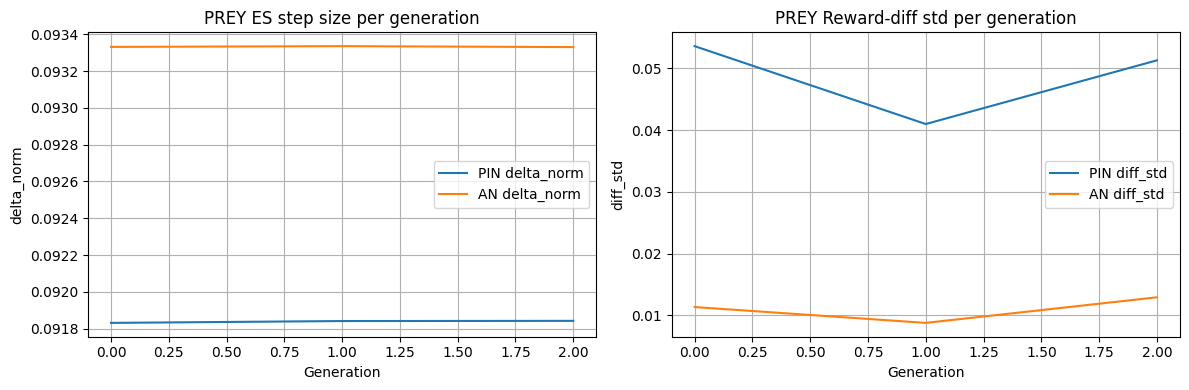

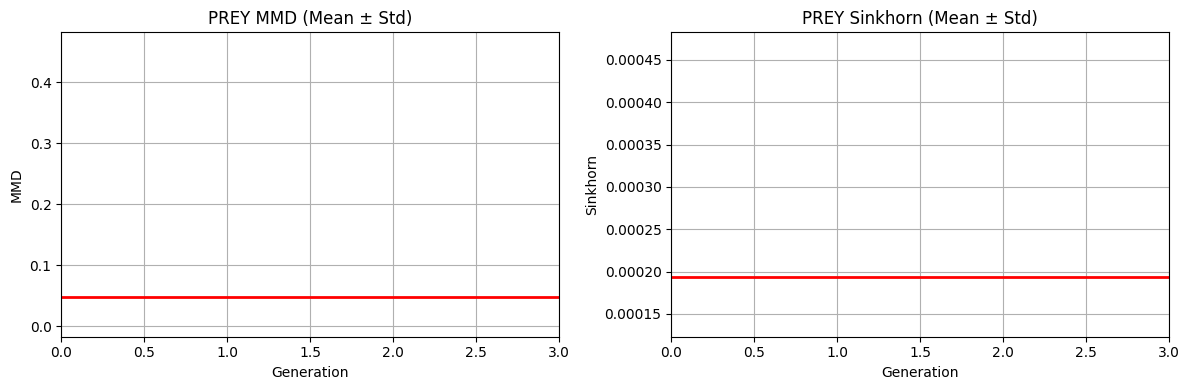

In [11]:
%matplotlib inline
# plot training and evaluation metrics for prey
plot_train_metrics(disc_metrics_list, prey_dis_balance_factor, role="prey", save_dir=run_dir)
plot_es_metrics(policy_metrics_list, role="prey", save_dir=run_dir)
plot_eval_metrics(metrics_list, role="prey", 
                  mmd_means=mmd_means, mmd_stds=mmd_stds, 
                  sinkhorn_means=sinkhorn_means, sinkhorn_stds=sinkhorn_stds, 
                  max_steps=num_generations, save_dir=run_dir)

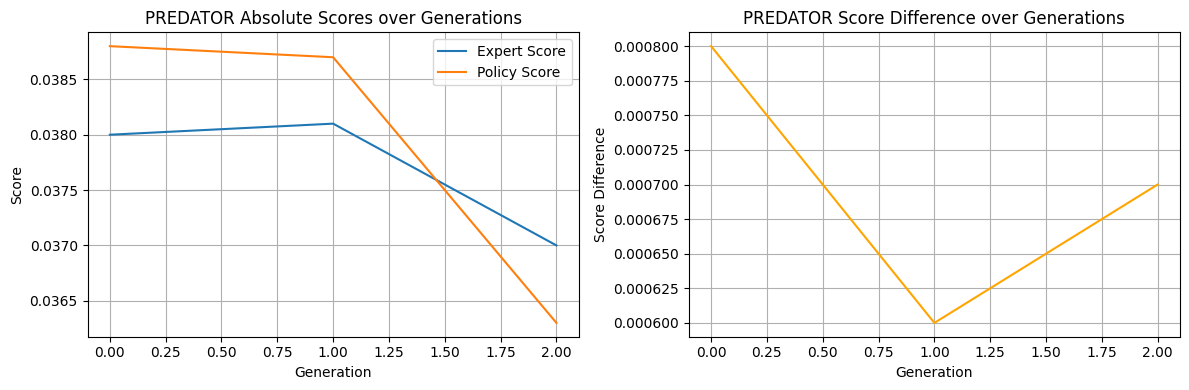

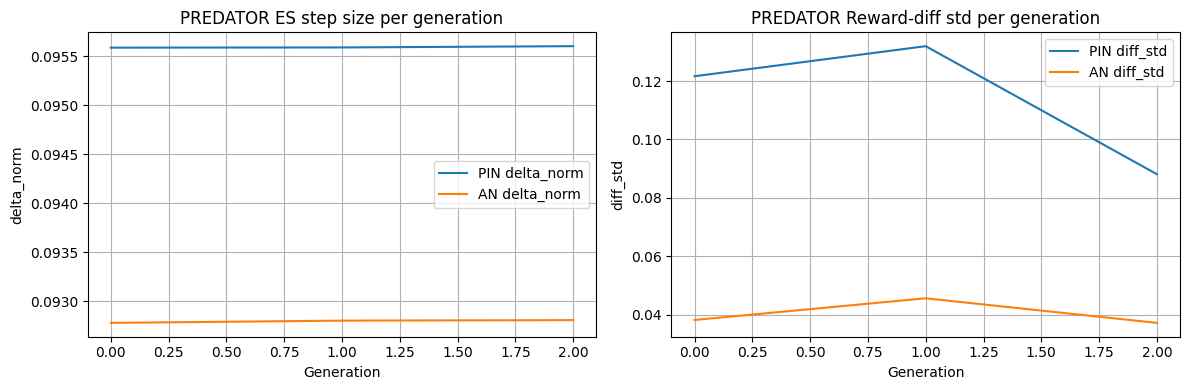

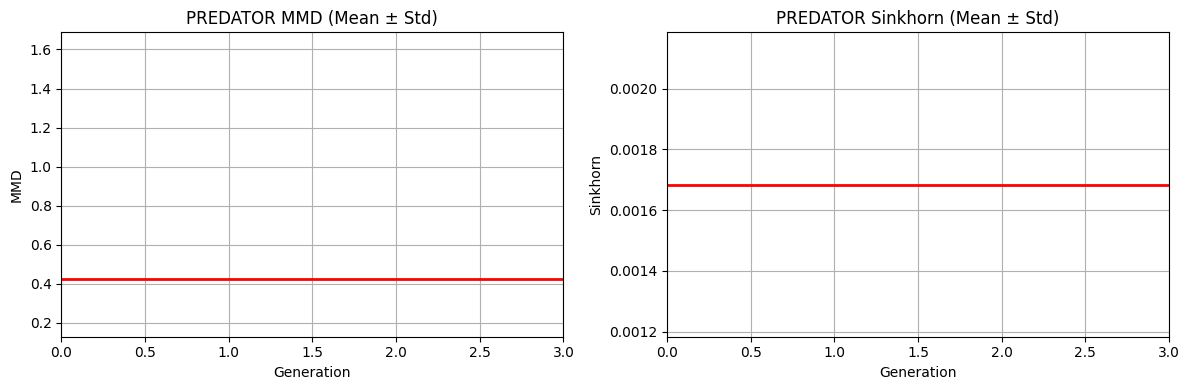

In [12]:
%matplotlib inline
# plot training and evaluation metrics for predator
plot_train_metrics(disc_metrics_list, pred_dis_balance_factor, role="predator", save_dir=run_dir)
plot_es_metrics(policy_metrics_list, role="predator", save_dir=run_dir)
plot_eval_metrics(metrics_list, role="predator", 
                  mmd_means=mmd_means, mmd_stds=mmd_stds, 
                  sinkhorn_means=sinkhorn_means, sinkhorn_stds=sinkhorn_stds, 
                  max_steps=num_generations, save_dir=run_dir)

In [13]:
%matplotlib tk
# visualize trained prey policy
gen_pred_tensor, gen_prey_tensor, gen_metrics = run_env_simulation(visualization='on', 
                                            prey_policy=prey_policy, pred_policy=pred_policy,
                                            n_prey=32, n_pred=1, 
                                            max_steps=100,
                                            pred_speed=pred_speed, prey_speed=prey_speed,
                                            area_width=width, area_height=height,
                                            max_turn = max_turn,
                                            step_size=step_size)

In [14]:
%matplotlib tk
# visualize expert data again
exp_pred_sequence, exp_prey_sequence, couzin_metrics, actions, init_pool = run_couzin_simulation(
                                        visualization="on", 
                                        max_steps=100, 
                                        constant_speed=prey_speed, shark_speed=pred_speed, 
                                        area_width=width, area_height=height,
                                        dt = step_size,
                                        alpha=0.01,
                                        theta_dot_max=theta_dot_max, theta_dot_max_shark=theta_dot_max,
                                        number_of_sharks=1, n=32)